In [8]:
# === ENVIRONMENT SETUP ===
import sys
from pathlib import Path
import shutil

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Remove old repo if exists
    if Path('Projects').exists():
        shutil.rmtree('Projects')

    # Clone fresh copy
    !git clone https://github.com/Q-types/Projects.git
    sys.path.insert(0, '/content/Projects')

# Import my utilities
from data_science.data_utils import ensure_dataset
from data_science.colab_setup import CFG, apply_style

print(f"✅ Setup complete! Data folder: {CFG.data_folder}")


Cloning into 'Projects'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 63 (delta 24), reused 44 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 2.12 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (24/24), done.
✅ Setup complete! Data folder: /content/Projects/data_science/datasets/raw


In [9]:
# === INSTALL PROPHET (Colab only) ===
if IN_COLAB:
    print("📦 Installing Prophet...")
    !pip install -q prophet
    print("✅ Prophet installed!")

# Re-install Prophet with necessary dependencies
if IN_COLAB:
    print("📦 Re-installing Prophet with dependencies...")
    !pip install -q --upgrade --no-cache-dir prophet cmdstanpy
    print("✅ Prophet re-installed!")

📦 Installing Prophet...
✅ Prophet installed!
📦 Re-installing Prophet with dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 212.8 MB/s eta 0:00:00
✅ Prophet re-installed!


In [10]:
import itertools
from tokenize import PlainToken
import pandas as pd
import numpy as np
from random import gauss
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Apply my custom plotting style (imported from cell 1)
apply_style('clean')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go

print("✅ Imports complete")



✅ Imports complete


📥 Downloading dataset 'us_covid' from Kaggle...
   Copied: us_energy.csv
   Copied: example_air_passengers.csv
   Copied: exp1.csv
   Copied: energy_daily.csv
   Copied: dataset_temperature.csv
   Copied: rossman_sales.csv
   Copied: quarterly_gdp_change.csv
   Copied: arma_series2.csv
   Copied: Sample - Superstore.xls
   Copied: ambient_temperature_system_failure.csv
   Copied: sunspots.csv
   Copied: arma_series1.csv
   Copied: irish_electricity_daily.csv
   Copied: outdoor-temperature-12UTC.csv
   Copied: example_wp_log_R_outliers1.csv
   Copied: medium_posts.csv
   Copied: passengers_test.csv
   Copied: avocado.csv
   Copied: Fremont_Bridge.csv
   Copied: passengers.csv
   Copied: irish_electricity_daily.xlsx
   Copied: example_wp_log_R_outliers2.csv
   Copied: tesla_prices_5y.csv
   Copied: passengers_train.csv
   Copied: diabetic.csv
   Copied: example_wp_log_peyton_manning.csv
   Copied: daily-minimum-temperatures-in-me.csv
   Copied: exp3.csv
   Copied: ex1_wiki_visits.csv
   

<Axes: >

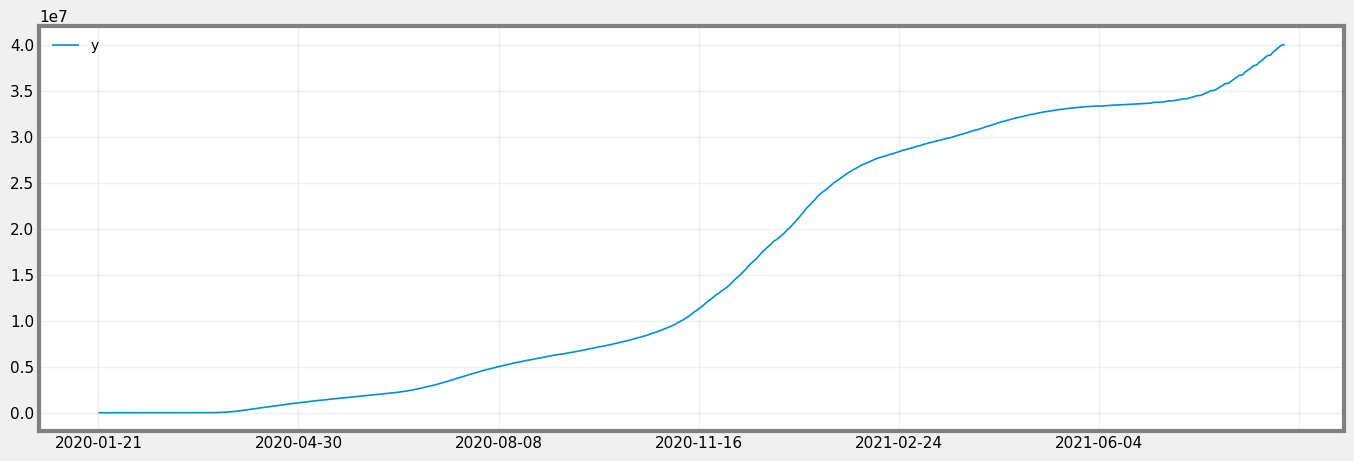

In [11]:
# Ensure dataset is available (downloads if needed)
data_folder = ensure_dataset("us_covid")

# Load data
df = pd.read_csv(data_folder / "us_covid.csv")
xdat = df[["date","cases"]].rename(columns={"date":"ds","cases":"y"})
xdat.set_index("ds").plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel="")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


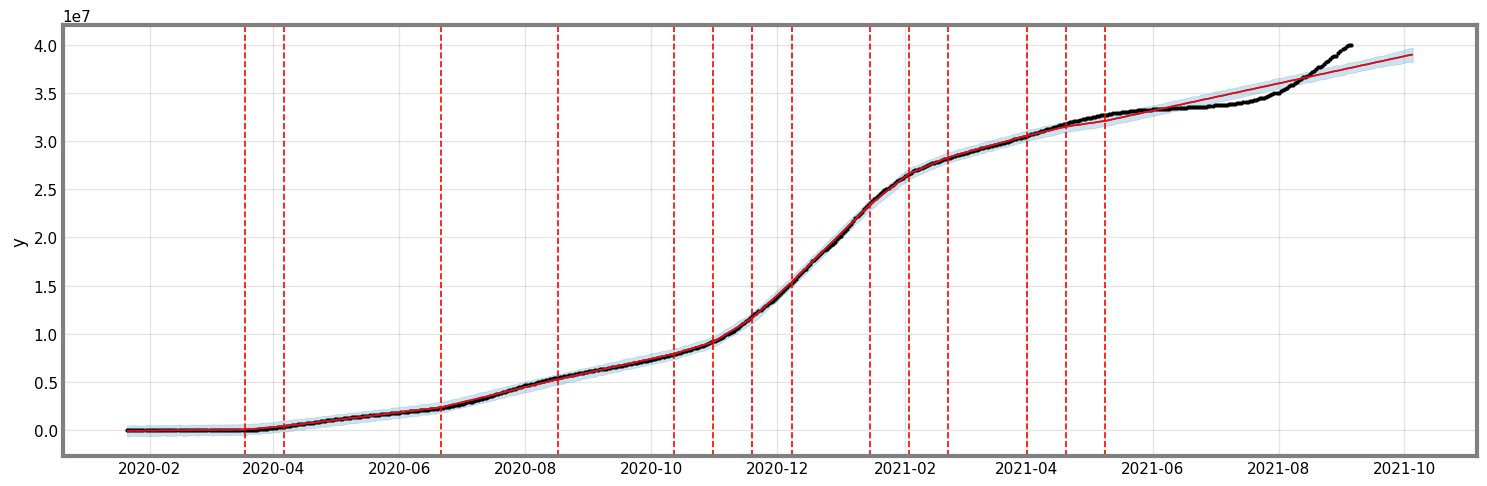

In [12]:


m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods=30)
forcast = m.predict(future)
fig = m.plot(forcast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forcast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


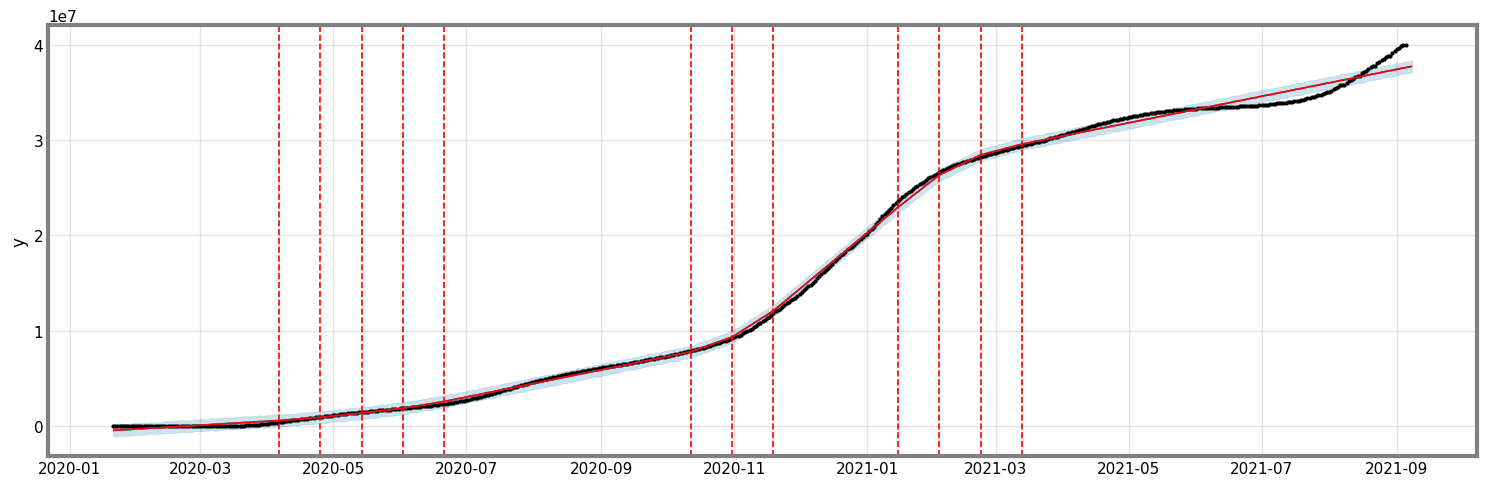

In [13]:
# automatic detection of change points
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods=3)
forcast = m.predict(future)
fig = m.plot(forcast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forcast)

In [14]:
# Ensure WHO dataset is available
ensure_dataset("who_cases")

# Load using CFG.data_folder
df = pd.read_csv(CFG.data_folder / "WHO_full_data2003.csv")

📥 Downloading dataset 'who_cases' from Kaggle...


100%|██████████| 107k/107k [00:00<00:00, 23.1MB/s]

Extracting files...
   Copied: WHO_full_data2003.csv
   Copied: API_SP.POP.TOTL_DS2_en_excel_v2_887218.xls
✅ Dataset ready at: /content/Projects/data_science/datasets/raw


<Axes: >

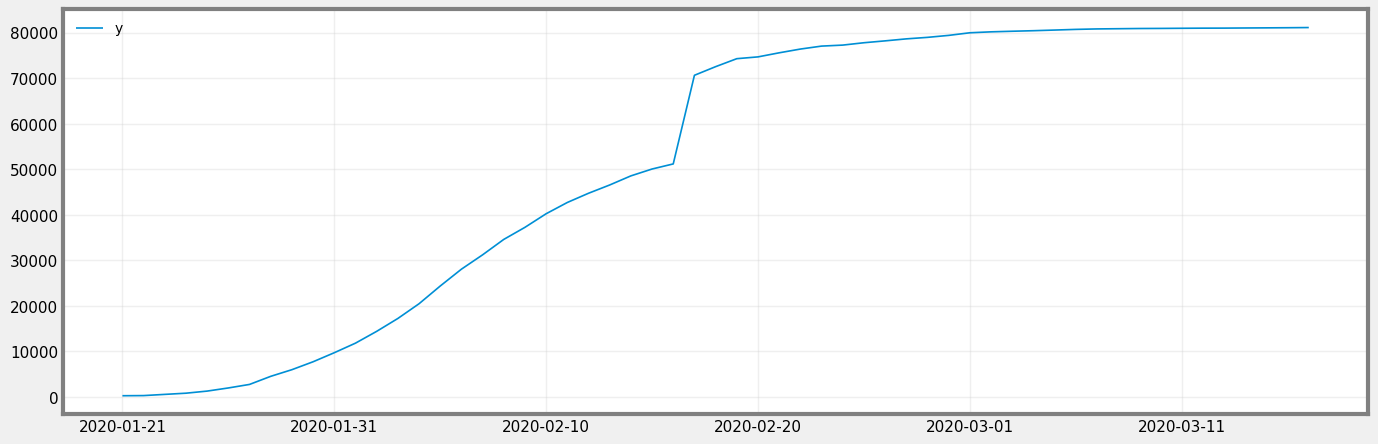

In [15]:
# Subset data and rename to Prophet naming convention

df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={'date':'ds', 'total_cases':'y'})
df.set_index('ds').plot(figsize=(CFG.img_dim1,CFG.img_dim2), xlabel='')

The curve of cases begins to flatten. Usign prophet we can incorporate such knowledge into the model by setting an upper bound

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


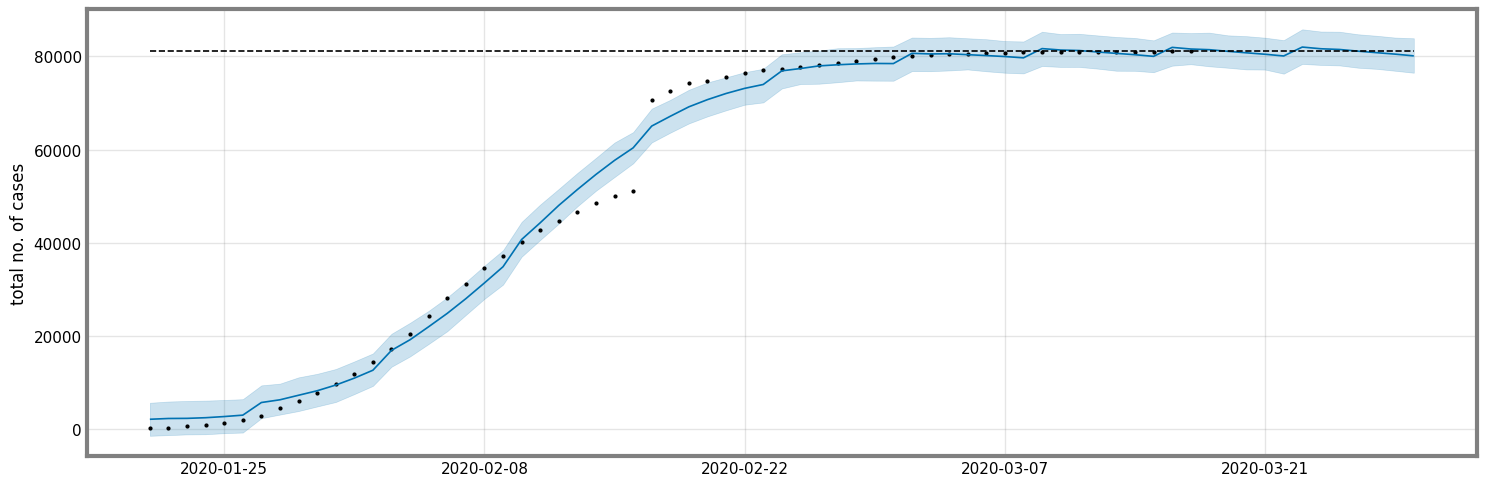

In [16]:
# adding cap

df['cap'] = df['y'].max()

# fit model
m = Prophet(growth='logistic')
m.fit(df)

# prediction
future = m.make_future_dataframe(periods=12)
future['cap'] = df['cap'].iloc[-1]

# plot results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total no. of cases')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


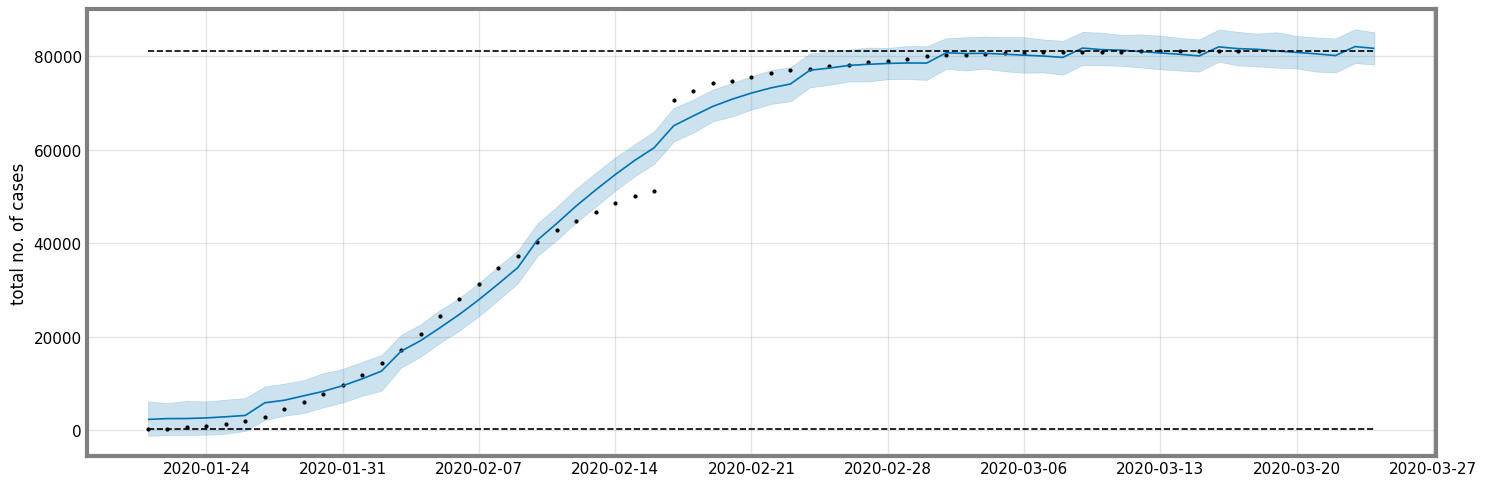

In [17]:
# now settign lower bounds

df['cap'] = df['y'].max()
df['floor'] = df['y'].min()

# fit model
m= Prophet(growth='logistic')
m.fit(df)

# prediction
future = m.make_future_dataframe(periods=7)
future['cap'] = df['cap'].iloc[-1]
future['floor'] = df['floor'].iloc[-1]
fcst = m.predict(future)

fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total no. of cases')

Seasonality

When dealing with dat in practical aplications, it is frewuently necessary to take into account multiple seasonal patterns occourring in parallel.

$$
S(t) = \sum_{i=1}^{N} \left( a_i \cos\left( \frac{2\pi i t}{P} \right) + b_i \sin\left( \frac{2\pi i t}{P} \right) \right)
$$

Now exploring how to specify different seasonalit patterns using energy consuption data form the PJM Interconnection LLC (PJM)

In [18]:
ensure_dataset("pjm_hourly")
df = pd.read_csv(CFG.data_folder / "pjm_hourly_est.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

📥 Downloading dataset 'pjm_hourly' from Kaggle...
Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.
   Copied: est_hourly.paruqet
   Copied: DOM_hourly.csv
   Copied: EKPC_hourly.csv
   Copied: DUQ_hourly.csv
   Copied: DAYTON_hourly.csv
   Copied: PJME_hourly.csv
   Copied: PJM_Load_hourly.csv
   Copied: NI_hourly.csv
   Copied: FE_hourly.csv
   Copied: COMED_hourly.csv
   Copied: AEP_hourly.csv
   Copied: pjm_hourly_est.csv
   Copied: DEOK_hourly.csv
   Copied: PJMW_hourly.csv
✅ Dataset ready at: /content/Projects/data_science/datasets/raw


,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


<Axes: xlabel='ds'>

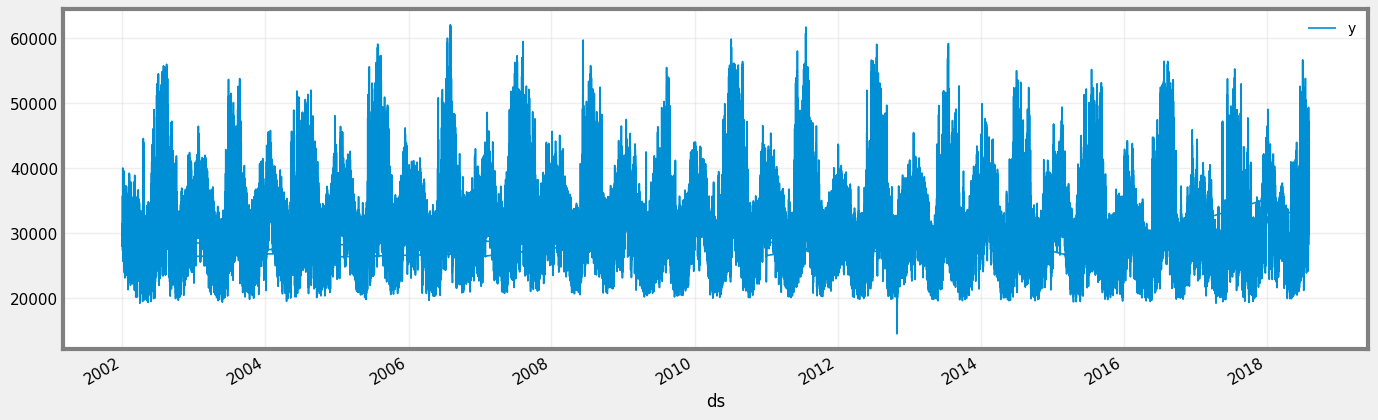

In [19]:
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={'Datetime':'ds', 'PJME':'y'})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


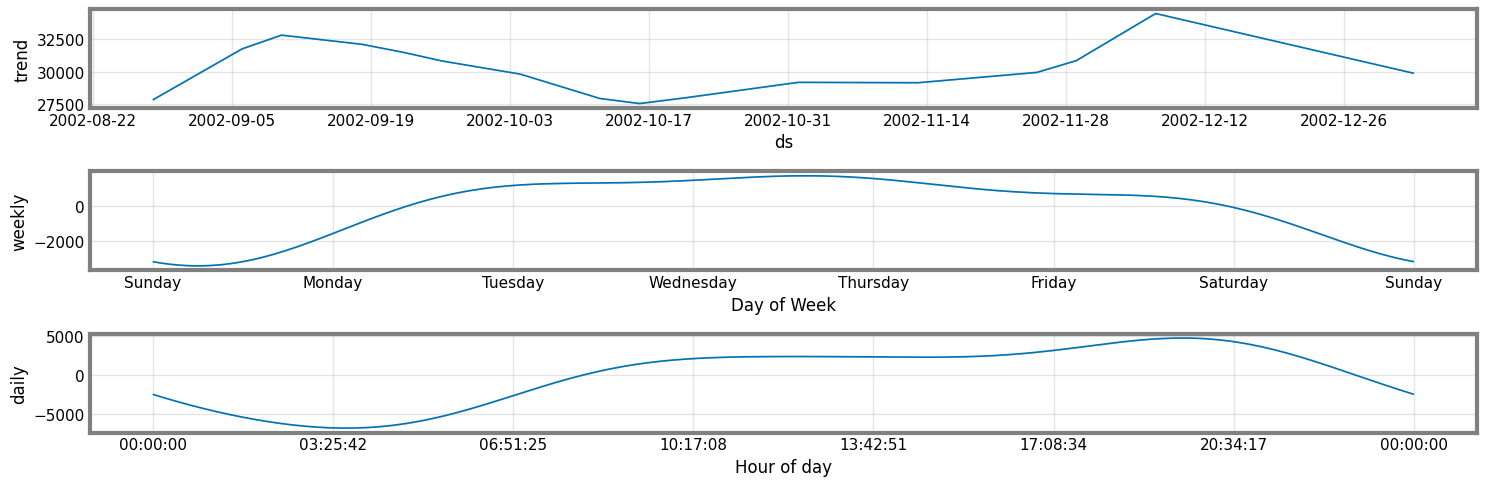

In [20]:
# we only need to keep at least two cycles, so reduce dataset with iloc

m = Prophet().fit(xdat.iloc[:3000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forcast = m.predict(future)
fig = m.plot_components(forcast, figsize=(CFG.img_dim1, CFG.img_dim2))


<Axes: >

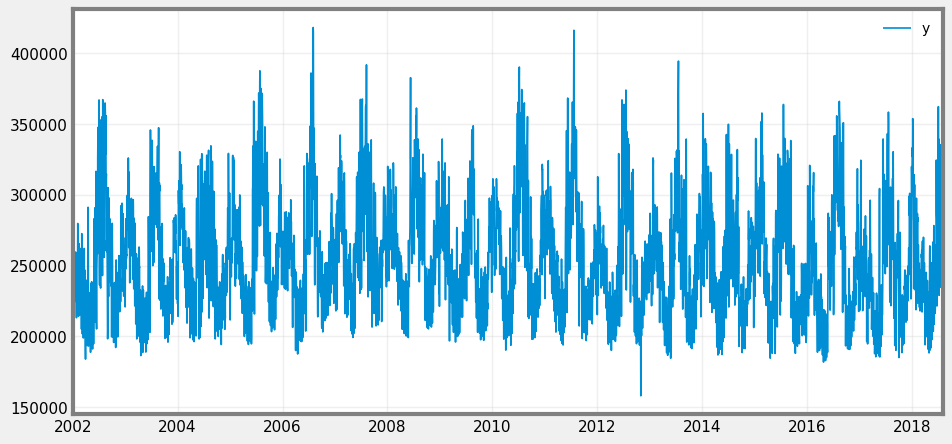

In [21]:
# agrigating the data to daily
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={'Datetime':'ds', 'PJME':'y'})
xdat['y'] /= 10^9

# purge the leading zeroes and last observation (which was partial)
ix = np.where(xdat['y'] > 0)[0][0]
xdat =xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


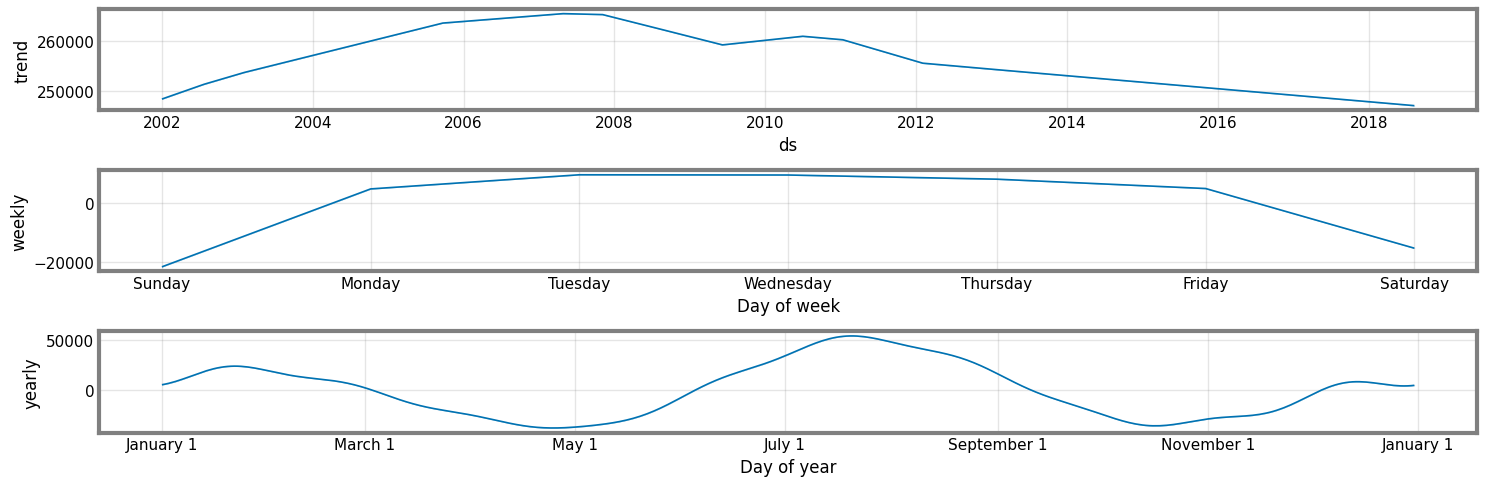

In [22]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forcast = m.predict(future)
fig = m.plot_components(forcast, figsize=(CFG.img_dim1, CFG.img_dim2))


<Axes: >

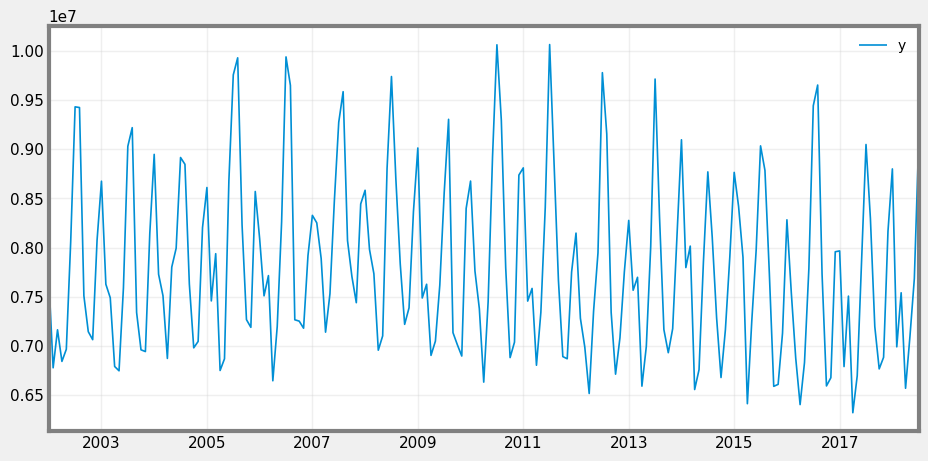

In [23]:
# downsampling further
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9

ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


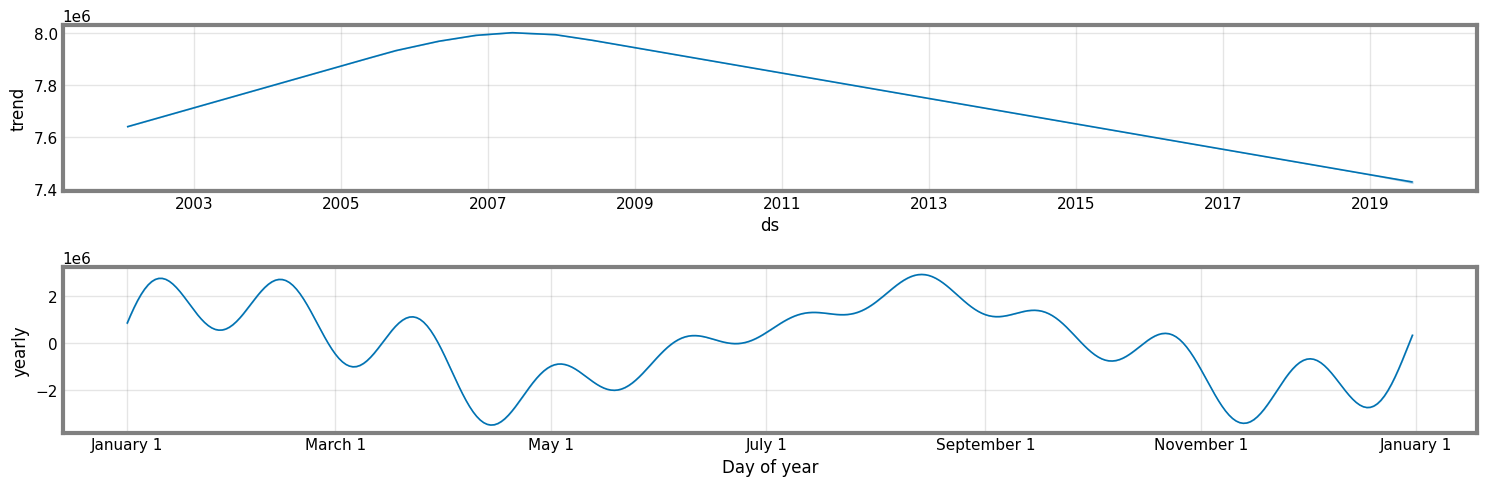

In [24]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forcast = m.predict(future)
fig = m.plot_components(forcast, figsize=(CFG.img_dim1, CFG.img_dim2))



$$
SeasonalitySpecification
$$

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ Dataset 'passengers' already available


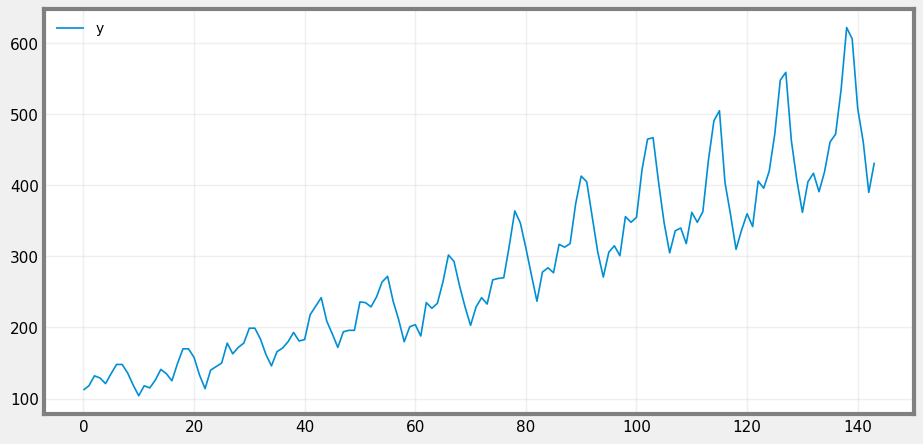

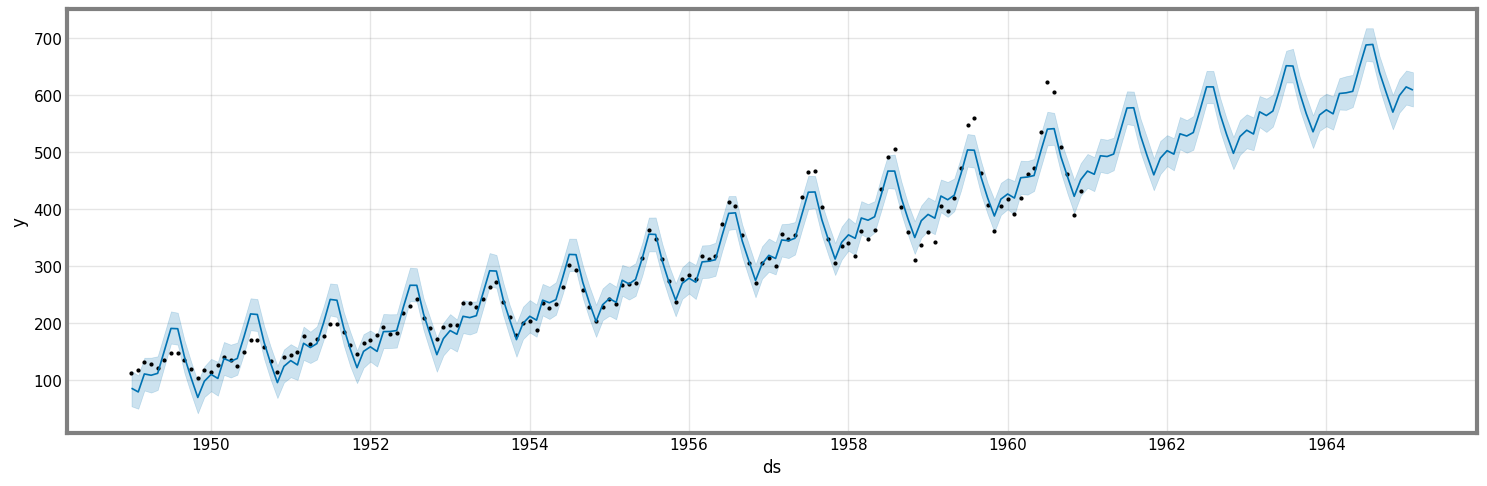

In [33]:
# Exploring seasonality_mode - addative and multiplicative

ensure_dataset("passengers")

df = pd.read_csv(CFG.data_folder / 'example_air_passengers.csv')

m = Prophet(seasonality_mode = 'additive')
m.fit(df)

future = m.make_future_dataframe(periods = 50, freq = 'MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


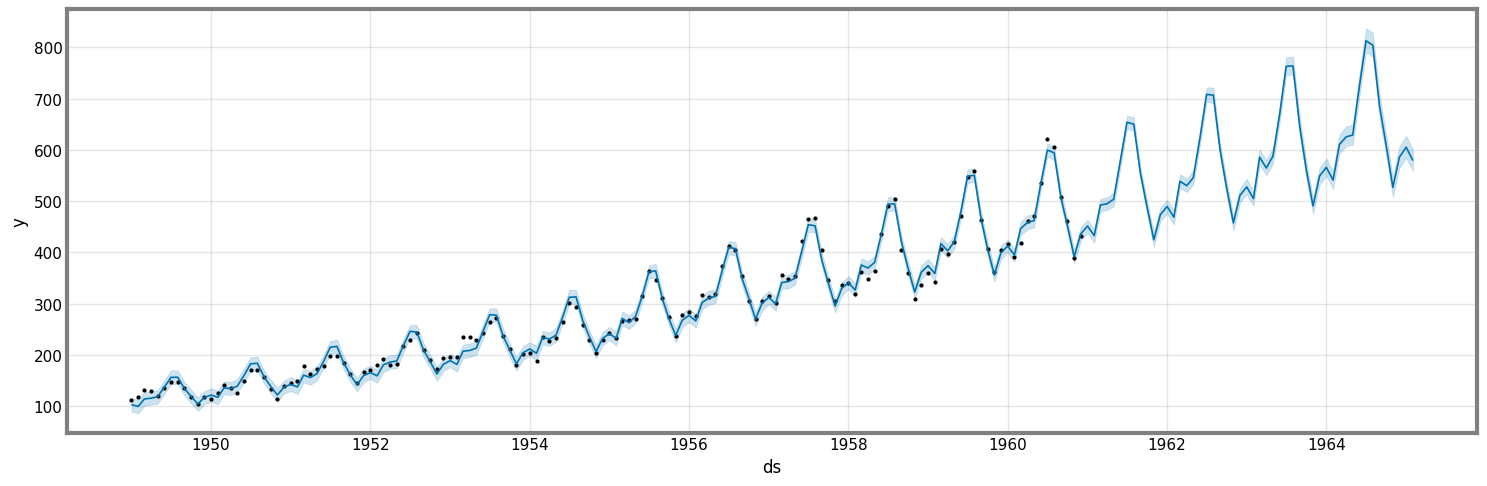

In [34]:
m = Prophet(seasonality_mode = 'multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))